In [39]:
import rebound
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from matplotlib.collections import PatchCollection
import matplotlib.transforms as transforms
from matplotlib import gridspec

In [3]:
twopi=np.pi*2
MEarth = 5.97e24
REarth = 6378.135e3
A=4. # m^2   -> effective cross section of satellite
albedo=0.2 # -> effective albedo 
EarthTilt=23.4 * np.pi/180

In [4]:
sim = rebound.Simulation()
sim.G = 6.67430e-11
sim.add(m=MEarth)

In [5]:
if 0:
    Ntest = 100
    for i in range(Ntest):
        sim.add(y=REarth+300e3,x=1.05*REarth*np.cos(i*np.pi*2./Ntest),z=1.05*REarth*np.sin(i*np.pi*2./Ntest))
        sim.add(y=REarth+300e3,x=.5*REarth*np.cos(i*np.pi*2./Ntest),z=.5*REarth*np.sin(i*np.pi*2./Ntest))
        sim.add(y=REarth+300e3,x=.25*REarth*np.cos(i*np.pi*2./Ntest),z=.25*REarth*np.sin(i*np.pi*2./Ntest))

In [6]:
if 1:
    ICs=[]
    ICs.append({'NPLANES':7178,'SATPP':1,'INC':30,'ALT':328}) # Starlink
    ICs.append({'NPLANES':7178,'SATPP':1,'INC':40,'ALT':334})
    ICs.append({'NPLANES':7178,'SATPP':1,'INC':53,'ALT':345})
    ICs.append({'NPLANES':40,'SATPP':50,'INC':96.9,'ALT':360})
    ICs.append({'NPLANES':1998,'SATPP':1,'INC':75,'ALT':373})
    ICs.append({'NPLANES':4000,'SATPP':1,'INC':53,'ALT':499})
    ICs.append({'NPLANES':12,'SATPP':12,'INC':148,'ALT':604})
    ICs.append({'NPLANES':18,'SATPP':18,'INC':115.7,'ALT':614})

    ICs.append({'NPLANES':2547,'SATPP':1,'INC':53,'ALT':345.6}) 
    ICs.append({'NPLANES':2478,'SATPP':1,'INC':48,'ALT':340.8})
    ICs.append({'NPLANES':2493,'SATPP':1,'INC':42,'ALT':335.9})
    ICs.append({'NPLANES':32,'SATPP':50,'INC':53,'ALT':550})
    ICs.append({'NPLANES':72,'SATPP':22,'INC':53.2,'ALT':540})
    ICs.append({'NPLANES':36,'SATPP':20,'INC':70,'ALT':570})
    ICs.append({'NPLANES':6,'SATPP':58,'INC':97.6,'ALT':560})
    ICs.append({'NPLANES':4,'SATPP':43,'INC':97.6,'ALT':560.1})
    
    ICs.append({'NPLANES':18,'SATPP':40,'INC':87.9,'ALT':1200}) # OneWeb
    ICs.append({'NPLANES':36,'SATPP':49,'INC':87.9,'ALT':1201})
    ICs.append({'NPLANES':32,'SATPP':72,'INC':40,'ALT':1202})
    ICs.append({'NPLANES':32,'SATPP':72,'INC':55,'ALT':1203})

    ICs.append({'NPLANES':16,'SATPP':30,'INC':85,'ALT':590}) # StarNet/GW
    ICs.append({'NPLANES':40,'SATPP':50,'INC':50,'ALT':600})
    ICs.append({'NPLANES':60,'SATPP':60,'INC':55,'ALT':508})
    ICs.append({'NPLANES':48,'SATPP':36,'INC':30,'ALT':1145})
    ICs.append({'NPLANES':48,'SATPP':36,'INC':40,'ALT':1145})
    ICs.append({'NPLANES':48,'SATPP':36,'INC':50,'ALT':1145})
    ICs.append({'NPLANES':48,'SATPP':36,'INC':60,'ALT':1145})

    ICs.append({'NPLANES':34,'SATPP':34,'INC':51.9,'ALT':630}) # Kuiper
    ICs.append({'NPLANES':36,'SATPP':36,'INC':42,'ALT':610})
    ICs.append({'NPLANES':28,'SATPP':28,'INC':33,'ALT':509})


    for ic in ICs:
        nplanes=ic['NPLANES']
        nsat=ic['SATPP']
        sma = ic['ALT']*1000.+REarth

        dplane=twopi/nplanes
        for ilocal in range(nsat):
            for iplane in range(nplanes):
                Omega = iplane*dplane
                sim.add(M="uniform",a=sma,omega=0,e=0,Omega=Omega,inc=ic['INC']*np.pi/180.)

In [7]:
sim.dt = sim.particles[1].P/15000.
sim.integrator = "whfast"
sim.N_active = 1

In [8]:
def rotY(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,0,-s],[0,1,0],[s,0,c]])
    return xyz @ M
def rotZ(xyz,alpha):
    c, s = np.cos(alpha), np.sin(alpha)
    M = np.array([[c,-s,0],[s,c,0],[0,0,1]])
    return xyz @ M
def lengthOfNight(timeOfYear,latitude, p=0):
    # https://www.ikhebeenvraag.be/mediastorage/FSDocument/171/Forsythe+-+A+model+comparison+for+daylength+as+a+function+of+latitude+and+day+of+year+-+1995.pdf
    # p=18 for astronomical twilight
    theta = 2.*np.arctan(0.9671396*np.tan(-timeOfYear/2.+np.pi/4.))
    phi = np.arcsin(0.39795*np.cos(theta))
    return 24./np.pi * np.arccos((np.sin(p*np.pi/180.)+np.sin(latitude*np.pi/180.)*np.sin(phi))/(np.cos(latitude*np.pi/180.)*np.cos(phi)))

In [9]:
def getStereographic(latitude, tilt, hour):
    sun = np.array([-1.4959787e+11,0,0]) # in m
    sun = rotY(sun, tilt)
    sun_n = sun/np.linalg.norm(sun)
    
    obs = np.array([REarth, 0, 0])
    obs = rotY(obs, -latitude)
    obs = rotZ(obs, hour)
    obs_n = obs/np.linalg.norm(obs)
    
    xyz = np.zeros((sim.N,3),dtype="float64")
    sim.serialize_particle_data(xyz=xyz)
    xyz = xyz[1:] # remove earth    


    lit = np.linalg.norm(np.cross(xyz,sun_n),axis=1)>REarth
    
    xyz = xyz[lit]
    
    xyz_n = xyz/np.linalg.norm(xyz,axis=1)[:,np.newaxis]
    xyz_r = xyz - obs
    xyz_rd = np.linalg.norm(xyz_r,axis=1)
    xyz_rn = xyz_r/xyz_rd[:,np.newaxis]
    
    phase = np.arccos(np.clip(np.dot(xyz_rn, -sun_n), -1.0, 1.0)) # assume sun is in -x direction
    
    fac1 = 2/(3*np.pi**2)
    magV = -26.74 -2.5*np.log10(fac1 * A * albedo * ( (np.pi-phase)*np.cos(phase) + np.sin(phase) ) ) + 5 * np.log10(xyz_rd)

        
    elevation = (np.pi/2.-np.arccos(np.dot(xyz_rn,obs_n)))/np.pi*180.
    
    xyz = rotZ(xyz, -hour)
    xyz = rotY(xyz, latitude)
    xyz_r = xyz - np.array([REarth, 0, 0])
    xyz_rd = np.linalg.norm(xyz_r,axis=1)
    xyz_rn = xyz_r/xyz_rd[:,np.newaxis]

    elevation_cut = 0
    xyz_rn = xyz_rn[elevation>elevation_cut]
    #magV = phase[elevation>elevation_cut]/np.pi*180.
    magV = magV[elevation>elevation_cut]


    return xyz_rn[:,1:3]/(1.+xyz_rn[:,0,np.newaxis]), magV

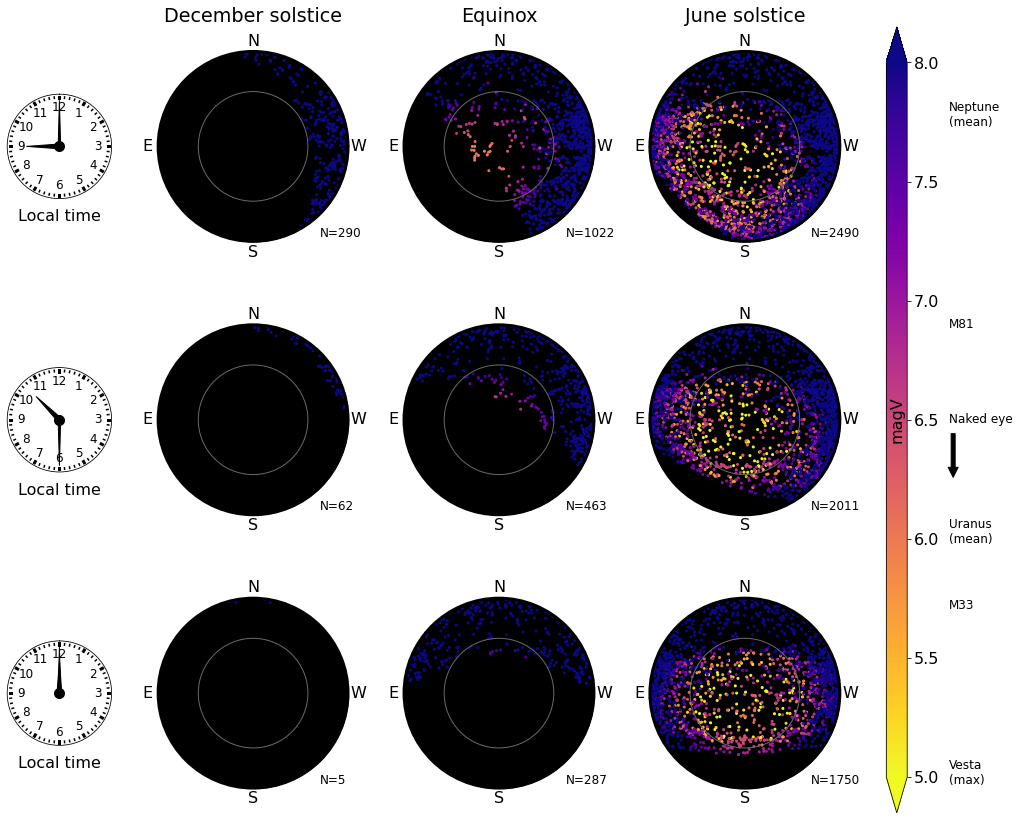

In [134]:
""
def getFig(latitude=50):    
    hours = [-3.,-1.5,0.]
    timesOfYear = {"December solstice":-np.pi/2.,"Equinox":0.,"June solstice":np.pi/2.}
    magVmin, magVmax =5, 8
    fontsize = 12


    cbwidth = 0.4
    fig = plt.figure(figsize=(2+cbwidth+4*len(timesOfYear),4*len(hours)))
    gs = gridspec.GridSpec(len(hours),len(timesOfYear)+2, width_ratios=[2.]+[4. for i in timesOfYear]+[cbwidth]) 

    cm = plt.cm.get_cmap('plasma_r')
    for i, hour in enumerate(hours):

        for j, timeOfYear in enumerate(timesOfYear):
            ax = plt.subplot(gs[1+j+i*(len(timesOfYear)+2)])
            if i==0:
                ax.set_title(timeOfYear,pad=20.)
            ax.set_aspect("equal")
            plot_size = 1.1
            ax.set_xlim(-plot_size,plot_size)
            ax.set_ylim(-plot_size,plot_size)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            # Background
            circle = plt.Circle((0, 0), 1)
            coll = PatchCollection([circle], zorder=-10, color="black")
            ax.add_collection(coll)
            
            # 30 degree 
            elevation = 30
            circle = plt.Circle((0, 0), np.cos(elevation/180.*np.pi)/(1.+np.sin(elevation/180.*np.pi)))
            coll = PatchCollection([circle], zorder=3,edgecolor="dimgray",facecolor="none")
            ax.add_collection(coll)
            elevation = 0.
            circle = plt.Circle((0, 0), np.cos(elevation/180.*np.pi)/(1.+np.sin(elevation/180.*np.pi)))
            coll = PatchCollection([circle], zorder=3,edgecolor="k",facecolor="none",lw=3)
            ax.add_collection(coll)


            tilt = 23.4*np.sin(timesOfYear[timeOfYear])

            xyzf_stereographic, magV = getStereographic(latitude/180.*np.pi, tilt/180.*np.pi, hour/12.*np.pi)
            im=ax.scatter(xyzf_stereographic[:,0],xyzf_stereographic[:,1],s=4, c=magV,cmap=cm,vmin=magVmin,vmax=magVmax)
            #im=ax.scatter(xyzf_stereographic[:,0],xyzf_stereographic[:,1],s=4,color="r")
            card_pos = 1.11
            ax.text(0,card_pos, "N",ha="center",va="center")
            ax.text(0,-card_pos, "S",ha="center",va="center")
            ax.text(card_pos,0, "W",ha="center",va="center")
            ax.text(-card_pos,0, "E",ha="center",va="center")
            ax.text(0.7,-0.95,"N=%d"%len(xyzf_stereographic),fontsize=fontsize)
    
        ax = plt.subplot(gs[i*(len(timesOfYear)+2)],projection="polar")
        marks = np.linspace(360./12,360,12, endpoint=True)
        ax.set_thetagrids(marks,map(lambda m: int(m/30),marks))
        ax.tick_params(pad=-24)
        for item in ax.get_xticklabels():
            item.set_fontsize(12)
        tick = [ax.get_rmax(),ax.get_rmax()*0.97]
        smallticks = np.linspace(0,np.pi*2.,12*5,endpoint=False)
        for t in smallticks:
            ax.plot([t,t], tick, lw=1.5, color="k")
        smallticks = np.linspace(0,np.pi*2.,12,endpoint=False)
        for t in smallticks:
            ax.plot([t,t], tick, lw=3, color="k")
        ax.set_theta_direction(-1)
        ax.set_theta_offset(np.pi/2)
        ax.grid(None)
        ax.get_yaxis().set_visible(False)
        ax.annotate("", xy=(hour/12*np.pi*2., 0.7),xytext=(0,0),arrowprops=dict(arrowstyle="wedge",fc="black",mutation_scale=15))
        mins = np.fmod(hour*60.,60.)
        ax.annotate("", xy=(mins/60.*np.pi*2., 0.96),xytext=(0,0),arrowprops=dict(arrowstyle="wedge",fc="black",mutation_scale=8))

        ax.scatter(0, 0, s=100, facecolors='k')
        ax.text(np.pi, 1.5, "Local time", ha="center")
     
    ax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(im,cax=ax,extend="both",shrink=10.3);
    #cb.ax.yaxis.set_ticks_position('left')
    #cb.ax.yaxis.set_label_position('left')

    trans = transforms.blended_transform_factory(cb.ax.transAxes, cb.ax.transData)
    x = 3.
    ha = "left"
    va = "center"
    cb.ax.text(6.5, (magVmin+magVmax)/2., "magV", va="center", ha="center", rotation=90)
    cb.ax.annotate("", xy=(x+0.2, 6.25),xytext=(x+0.2, 6.45),ha=ha,arrowprops=dict(arrowstyle="simple",fc="black",mutation_scale=20),xycoords=trans,textcoords=trans)
    cb.ax.annotate("Naked eye", xy=(x,6.5),zorder=10,ha=ha,va=va, xycoords=trans,fontsize=fontsize)
    cb.ax.annotate("Neptune\n(mean)", xy=(x,7.78),zorder=10,ha=ha,va=va,xycoords=trans,fontsize=fontsize)
    cb.ax.annotate("Uranus\n(mean)", xy=(x,6.03),zorder=10,ha=ha,va=va,xycoords=trans,fontsize=fontsize)
    cb.ax.annotate("Vesta\n(max)", xy=(x,5.02),zorder=10,ha=ha,va=va,xycoords=trans,fontsize=fontsize)
    cb.ax.annotate("M33", xy=(x,5.72),zorder=10,ha=ha,va=va,xycoords=trans,fontsize=fontsize)
    cb.ax.annotate("M81", xy=(x,6.9),zorder=10,ha=ha,va=va,xycoords=trans,fontsize=fontsize)

    fig.tight_layout()
    
    return fig
matplotlib.rcParams.update({'font.size': 16})
fig = getFig();
#fig.savefig("plot_00000.png", facecolor="white", dpi=200,bbox_inches='tight')